# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Филин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = - \sum_j \frac{y^{(j)} x_i^{(j)}}{1+e^{y^{(j)} g(x^{(i)})}} + \frac{2w_i}{C} $$

## Имплементация (5 баллов)

In [129]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import shuffle


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=24):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
    
    
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def cost_function(self, X, y, W):
        loss = - 1.0 / self.num_items * np.sum(np.log(self.sigmoid(y * np.dot(X, W))))
        reg = 1.0 / self.C * (np.dot(W.T, W))
        return loss + reg
    
    def fit(self, X, y):
        '''
        Обучение модели
        '''

        X = np.c_[np.ones((X.shape[0], 1)), X] # припишем единицы к матрице X слева (дополнительный признак для w0)
        y = (y-0.5)*2  # приведем метки классов к -1 и 1
        
        self.num_items = X.shape[0]
        self.n_batches = int(self.num_items / self.batch_size)
    
        self.W = np.random.random(X.shape[1])
        self.losses = np.empty(self.max_epoch)
        
        for n_epoch in xrange(self.max_epoch):
            X, y = shuffle(X, y, random_state=100) # перемешиваем данные
            for j in xrange(self.n_batches):
                batch_idx = np.arange(j * self.batch_size, min((j + 1) * self.batch_size, self.num_items))
                X_batch = X[batch_idx]
                y_batch = y[batch_idx]
                
                grad = -np.dot(y_batch * self.sigmoid(-y_batch * X_batch.dot(self.W)), X_batch) + 2./self.C * self.W   
                self.W = self.W - self.alpha / (1 + n_epoch) * grad
                
            self.losses[n_epoch] = np.sum(np.log(1 + np.e**(-y * X.dot(self.W))))
                
        return self
    
    def get_weights(self):
        return self.W
    
    def get_errors_epoch(self):
        return self.losses
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = np.c_[np.ones((X.shape[0], 1)), X]
        y_hat = np.sign(X.dot(self.W)) / 2 + 0.5
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.c_[np.ones((X.shape[0], 1)), X]
        y_hat_proba = np.c_[self.sigmoid(X.dot(self.W)), self.sigmoid(-X.dot(self.W))]
        
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

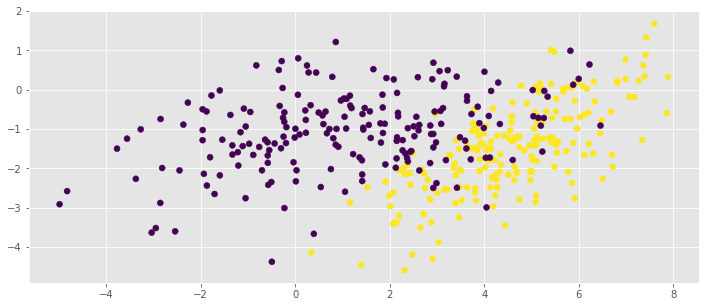

In [35]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [36]:
X.shape

(400, 2)

In [37]:
logreg = MySGDClassifier(max_epoch=40, C=100, batch_size=32, alpha=0.04)
logreg.fit(X, y)

MySGDClassifier(C=100, alpha=0.04, batch_size=32, max_epoch=40)

In [38]:
w = logreg.W
w

array([-3.54409289,  0.84397866, -0.83030298])

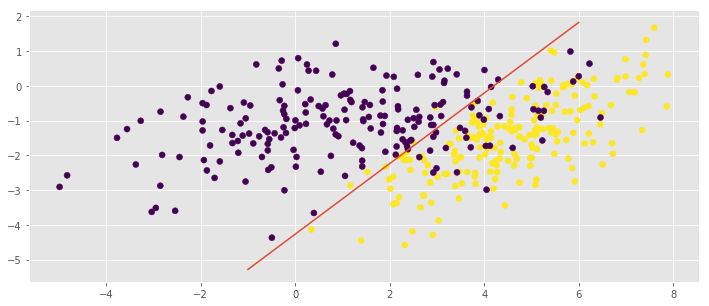

In [39]:
plt.scatter(X[:,0], X[:,1], c=y)
x = np.arange(-1, 7, 1)
plt.plot(x, -w[1]/w[2]*x - w[0]/w[2])

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [33]:
from sklearn.datasets import make_classification

In [34]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

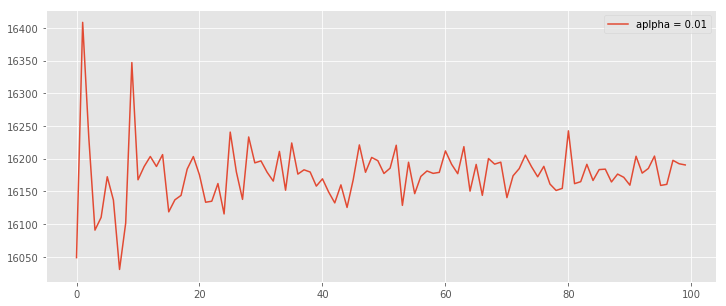

In [49]:
## Your Code Here
#alpha = 0.01
model1 = MySGDClassifier(alpha=0.01, max_epoch=100)
model1.fit(X, y)
losses1 = model1.get_errors_epoch()
plt.plot(range(losses1.shape[0]), losses1, label='aplpha = 0.01')
plt.legend()

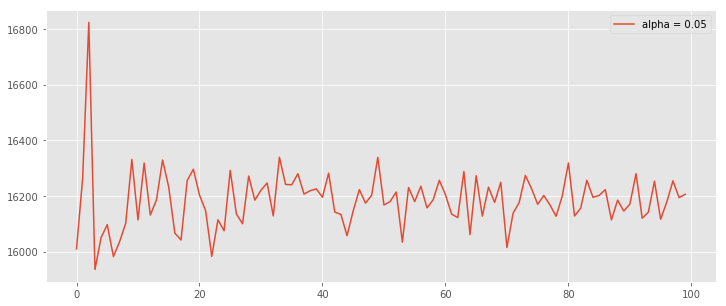

In [51]:
#alpha = 0.05
model2 = MySGDClassifier(alpha=0.05, max_epoch=100)
model2.fit(X, y)
losses2 = model2.get_errors_epoch()
plt.plot(range(losses2.shape[0]), losses2, label='alpha = 0.05')
plt.legend()

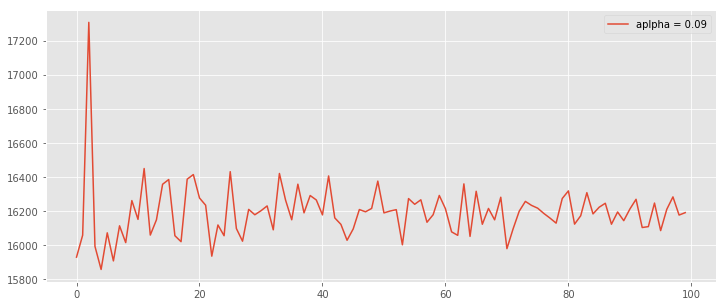

In [52]:
#alpha = 0.09
model3 = MySGDClassifier(alpha=0.09, max_epoch=100)
model3.fit(X, y)
losses3 = model3.get_errors_epoch()
plt.plot(range(losses3.shape[0]), losses3, label='aplpha = 0.09')
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [36]:
import tqdm

 80%|████████  | 8/10 [00:08<00:02,  1.12s/it]/Users/maksim/anaconda/envs/tsenv27/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/maksim/anaconda/envs/tsenv27/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in multiply
100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


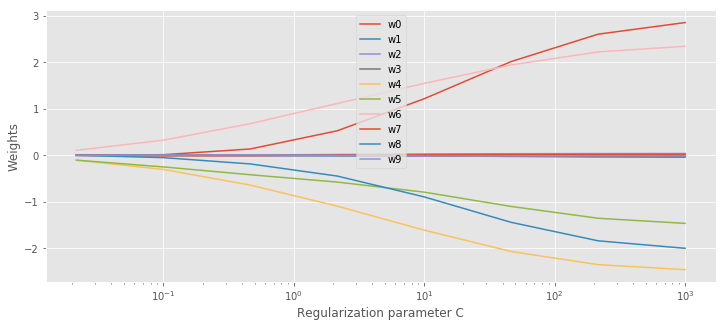

In [37]:
## Your Code Here
weights = []
n_features = X.shape[1]
for C in tqdm.tqdm(np.logspace(3, -3, 10)):
    model = MySGDClassifier(C=C, alpha=0.01, max_epoch=10)
    model.fit(X, y)
    ws = model.get_weights()
    weights.append(ws)

weights = np.array(weights)

for i in xrange(n_features):
    plt.plot(np.logspace(3,-3, 10), weights[:,i], label='w'+str(i))

plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('Weights')
plt.legend()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [320]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './data/trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
#df_train_data = pd.read_csv("./data/trainingData_tabular_chunk1.csv", sep=',')

In [234]:
df_test_data = pd.read_csv("./data/trainingData_tabular_chunk2.csv", sep=',')

In [266]:
df_data = pd.concat([df_train_data, df_test_data], axis=0)

In [321]:
df_data = df_data.drop_duplicates()

In [322]:
df_data.shape

(2000000, 45)

In [323]:
df_data.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,4687346.0,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826.0,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487.0,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946.0,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127.0,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14


In [324]:
y_train = df_data[['decision']]
y_train.head()

,decision
0,1
1,1
2,1
3,1
4,0


In [325]:
df_data.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,4687346.0,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826.0,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487.0,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946.0,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127.0,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14


In [326]:
for column_name in df_data.columns.values:
    print column_name, len(df_data[column_name].unique())

gamestate_id 2000000
decision 2
turn 31
opponent.armor 22
opponent.attack 6
opponent.hero_card_id 9
opponent.hp 30
opponent.special_skill_used 2
opponent.weapon_durability 5
opponent.crystals_all 11
opponent.crystals_current 11
opponent.deck_count 27
opponent.fatigue_damage 8
opponent.hand_count 11
opponent.played_minions_count 8
player.armor 21
player.attack 8
player.hero_card_id 9
player.hp 30
player.special_skill_used 2
player.weapon_durability 5
player.crystals_all 10
player.crystals_current 11
player.deck_count 27
player.fatigue_damage 7
player.hand_count 11
player.played_minions_count 8
opponent.played.nOfCards 8
opponent.played.attack 50
opponent.played.crystals_cost 40
opponent.played.hp_current 46
opponent.played.hp_max 56
player.played.nOfCards 8
player.played.attack 60
player.played.crystals_cost 42
player.played.hp_current 47
player.played.hp_max 56
player.hand.nOfMinions 11
player.hand.nOfSpells 9
player.hand.nOfWeapons 5
player.hand.nOfCards 11
player.hand.nOfPlayable 11


In [327]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [328]:
df_data.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
gamestate_id,,,,,,,,,,,,,,,,,,,,,
4687346.0,1,14,0,0,798,5,0,0,10,10,...,20,23,4,0,1,5,0,20,22,17
3270826.0,1,7,0,0,754,22,0,0,6,6,...,16,17,3,2,2,7,0,17,26,20
3189487.0,1,5,3,0,612,29,0,0,4,1,...,0,0,5,0,0,5,2,26,28,27
4098946.0,1,8,0,0,390,26,0,0,7,7,...,2,2,7,1,1,9,9,36,44,36
2661127.0,0,13,0,0,25,30,0,0,10,1,...,7,7,4,0,0,4,4,13,13,14


In [329]:
# Распределение классов
# df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [330]:
## Youd Code Here
print "uniqie opponent hero card ids:", df_data.opponent_hero_card_id.unique()
print "unique player hero card ids:", df_data.player_hero_card_id.unique() 
print "количество уникальных карт героя у оппонента", len(df_data.opponent_hero_card_id.unique())
print "количество уникальных карт героя у игрока ", len(df_data.player_hero_card_id.unique())

uniqie opponent hero card ids: [ 798  754  612  390   25 1235  494  981  326]
unique player hero card ids: [ 981  754  612  494   25 1235  326  390  798]
количество уникальных карт героя у оппонента 9
количество уникальных карт героя у игрока  9


In [331]:
categorial = ['player_hero_card_id', 'opponent_hero_card_id']

In [332]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [333]:
cat_player = pd.get_dummies(df_data['player_hero_card_id'])
cat_oppo = pd.get_dummies(df_data['opponent_hero_card_id'])

In [334]:
player_names = ["player_" + str(value) for value in cat_player.columns.values]
player_names

['player_25',
 'player_326',
 'player_390',
 'player_494',
 'player_612',
 'player_754',
 'player_798',
 'player_981',
 'player_1235']

In [335]:
oppo_names = ["oppo_" + str(value) for value in cat_player.columns.values]
oppo_names

['oppo_25',
 'oppo_326',
 'oppo_390',
 'oppo_494',
 'oppo_612',
 'oppo_754',
 'oppo_798',
 'oppo_981',
 'oppo_1235']

In [336]:
cat_player.columns = player_names

In [337]:
cat_player.head()

,player_25,player_326,player_390,player_494,player_612,player_754,player_798,player_981,player_1235
gamestate_id,,,,,,,,,
4687346.0,0,0,0,0,0,0,0,1,0
3270826.0,0,0,0,0,0,1,0,0,0
3189487.0,0,0,0,0,1,0,0,0,0
4098946.0,0,0,0,0,0,0,0,1,0
2661127.0,0,0,0,1,0,0,0,0,0


In [338]:
cat_oppo.columns = oppo_names

In [339]:
cat_oppo.head()

,oppo_25,oppo_326,oppo_390,oppo_494,oppo_612,oppo_754,oppo_798,oppo_981,oppo_1235
gamestate_id,,,,,,,,,
4687346.0,0,0,0,0,0,0,1,0,0
3270826.0,0,0,0,0,0,1,0,0,0
3189487.0,0,0,0,0,1,0,0,0,0
4098946.0,0,0,1,0,0,0,0,0,0
2661127.0,1,0,0,0,0,0,0,0,0


In [340]:
df_cat = pd.concat([cat_player, cat_oppo], axis=1)

In [341]:
df_cat.head()

,player_25,player_326,player_390,player_494,player_612,player_754,player_798,player_981,player_1235,oppo_25,oppo_326,oppo_390,oppo_494,oppo_612,oppo_754,oppo_798,oppo_981,oppo_1235
gamestate_id,,,,,,,,,,,,,,,,,,
4687346.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3270826.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3189487.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4098946.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2661127.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [342]:
df_data.shape

(2000000, 44)

In [343]:
df_cat.shape

(2000000, 18)

In [344]:
df_data_cat = pd.concat([df_cat, df_data], axis=1)

In [345]:
df_data_cat.shape

(2000000, 62)

In [346]:
df_data_cat.head()

,player_25,player_326,player_390,player_494,player_612,player_754,player_798,player_981,player_1235,oppo_25,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
gamestate_id,,,,,,,,,,,,,,,,,,,,,
4687346.0,0,0,0,0,0,0,0,1,0,0,...,20,23,4,0,1,5,0,20,22,17
3270826.0,0,0,0,0,0,1,0,0,0,0,...,16,17,3,2,2,7,0,17,26,20
3189487.0,0,0,0,0,1,0,0,0,0,0,...,0,0,5,0,0,5,2,26,28,27
4098946.0,0,0,0,0,0,0,0,1,0,0,...,2,2,7,1,1,9,9,36,44,36
2661127.0,0,0,0,1,0,0,0,0,0,1,...,7,7,4,0,0,4,4,13,13,14


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [347]:
data = df_data_cat.drop_duplicates()
data.shape

(1993987, 62)

In [348]:
par = 0.8
num = int(df_data_cat.shape[0] * par)

In [349]:
train = df_data_cat.iloc[:num]
test = df_data_cat.iloc[num:]

In [350]:
y_train = train['decision']
y_test = test['decision']

In [351]:
X_train = train.drop(['decision'], axis=1)

In [352]:
X_test = test.drop(['decision'], axis=1)

In [353]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [354]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(1600000, 61)
(400000, 61)
(1600000,)
(400000,)


In [297]:
from sklearn.preprocessing import StandardScaler

In [356]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [358]:
X_test = scaler.fit_transform(X_test)

In [357]:
model_logreg = MySGDClassifier(alpha=0.01, max_epoch=100, C=10)
model_logreg.fit(X_train, y_train)

MySGDClassifier(C=10, alpha=0.01, batch_size=24, max_epoch=100)

In [359]:
pred = model_logreg.predict(X_test)

In [312]:
## Youd Code Here
pipe_logreg = Pipeline([('scaler', scaler), ('logreg', model_logreg)])

In [ ]:
pipe_logreg.fit(X_train, train_y)

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [316]:
from sklearn.metrics import roc_auc_score

In [360]:
## Youd Code Here
roc_auc_score(pred, y_test)

0.71285253861952946